# FACTS devices

# We implement the FACTS devices based on the following source:

    A. Panosyan, "Modeling of advanced power transmission system controllers",
    Ph.D. dissertation, Gottfried Wilhelm Leibniz Universität Hannover, 2010.

We reproduce the case study from the source using the following grid model:

![title](facts/facts_case_study_grid.png)

So far, we have implemented the following FACTS devices:
- Static Var Compensator (SVC)
- Static Synchronous Compensator (SSC) 
- Thyristor-Controlled Series Capacitor (TCSC)

## Reference: case study grid

First, we import the required functions and set up plotting, the grid model and the data for the timeseries simulation.

In [1]:
import os
import tempfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pandapower as pp
from pandapower.test.loadflow.test_facts import facts_case_study_grid
from pandapower.timeseries import DFData, OutputWriter
from pandapower.timeseries.run_time_series import run_timeseries
from pandapower.control import ConstControl
from pandapower.pf.create_jacobian_facts import calc_y_svc_pu

In [2]:
def plot_result(ax, result, title, ylabel, ylim=None, yticks=None, legend=False, legend_kwargs=None):
    result.plot(ax=ax, legend=False)
    if legend:
        kwargs = dict() if legend_kwargs is None else legend_kwargs
        ax.legend(**kwargs)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Time (h)")
    ax.set_xscale('linear')
    locs = np.array([-24,   0,  24,  48,  72,  95])
    labels = ['00:00','00:00','06:00','12:00','18:00',"23:45"]
    ax.set_xticks(locs, labels)
    ax.set_xlim([0, 95])
    if ylim is not None:
        ax.set_ylim(ylim)
    if yticks is not None:
        ax.set_yticks(yticks)

In [3]:
net = facts_case_study_grid()

c:\users\rbolgaryn\repos\pandapower\pandapower\create.py:4893: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Yy0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  net[element_type].at[index, column] = value


All loads are considered constant. The output of the wind park is configured via a wind power profile. 
The plot below shows the wind power profile used in the timeseries simulation:

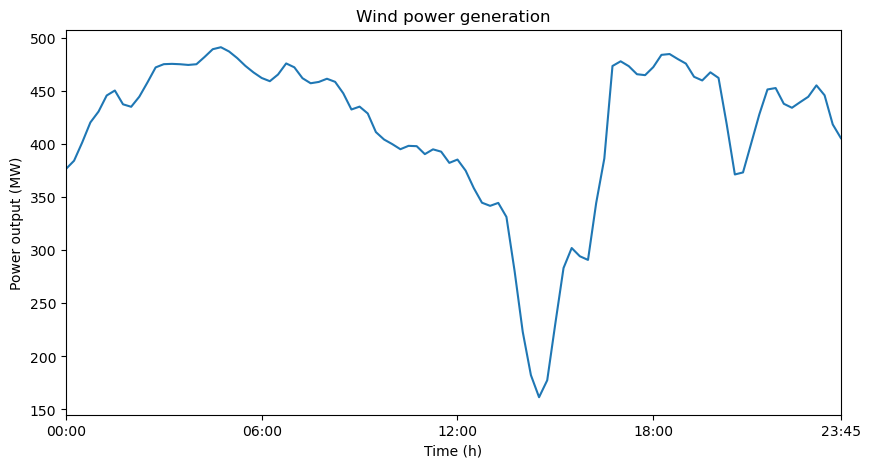

In [4]:
#### define and prepare the generation and load profiles.

wind_profile = pd.read_csv(r"facts/facts_case_study_wind_profile.csv", index_col=0)

_, (ax) = plt.subplots(1, 1, figsize=(10, 5))
plot_result(ax, wind_profile, "Wind power generation", "Power output (MW)")

In [5]:
time_steps = wind_profile.index.values
wind_ds = DFData(wind_profile)
ConstControl(net, element='gen', variable='p_mw', element_index=net.gen.index,
             data_source=wind_ds, profile_name=["wind_power_mw"])

ow = OutputWriter(net, time_steps, output_path=None)
ow.log_variable("res_bus", "vm_pu")
ow.log_variable("res_trafo", "q_hv_mvar")
ow.log_variable("res_trafo", "q_lv_mvar")
ow.log_variable("res_gen", "p_mw")

In [6]:
run_timeseries(net, time_steps, continue_on_divergence=False, recycle=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:03<00:00, 27.19it/s]


We do not include the buses "B1" and "B2" in the result plots because their voltage magnitude is always 1 p.u.
The results of the timeseries simulation for the bus voltages is are shown in the plot below:

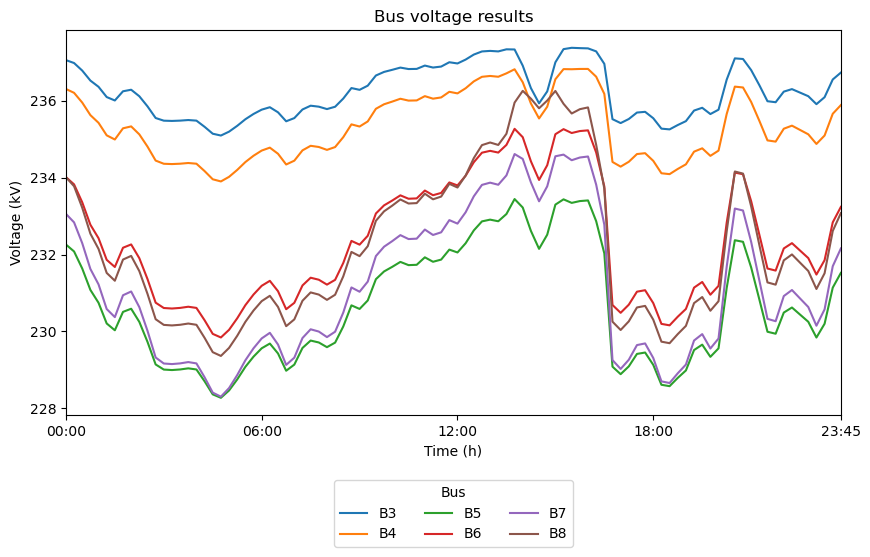

In [7]:
vm_pu = ow.output["res_bus.vm_pu"].copy()
vm_pu.columns = net.bus.name.values

_, (ax) = plt.subplots(1, 1, figsize=(10, 5))
legend_kwargs = {"loc": "upper center", "bbox_to_anchor": (0.5, -0.15), "title": "Bus","ncol":3}
plot_result(ax, 230 * vm_pu.iloc[:, 2:], "Bus voltage results", "Voltage (kV)", legend=True, legend_kwargs=legend_kwargs)


In [8]:
vm_pu.columns

Index(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8'], dtype='object')

## SVC use case

The element SVC is a shunt-connected thyristor-based power electronic device. It regulates the voltage magnitude at the
connected bus by adjusting the shunt impedance value. The shunt impedance only has the reactance component
(no resistive part). The impedance can be capacitive or inductive, because the device consists of a fixed capacitor in
a parallel circuit to the reactor that is regulated by a pair of antiparallel thyristors.
The thyristor firing angle regulates the total impedance of the element. The device operates in the value range of the thyristor firing angle between 90° and 180°.

The active range of the device is presented in the figure below:

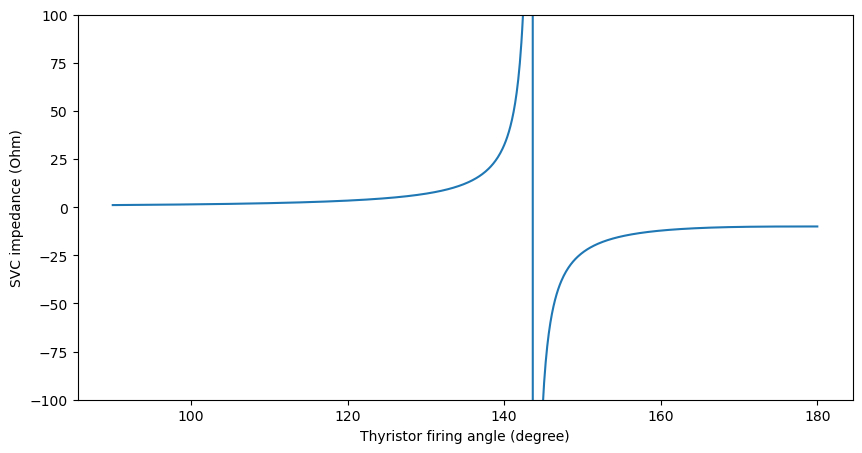

In [9]:
baseV = 230
baseMVA = 1
baseZ = baseV ** 2 / baseMVA

x = np.arange(90,180.1, 0.1)
y = calc_y_svc_pu(np.deg2rad(x), 1 / baseZ, -10 / baseZ)

_, (ax) = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(x, 1 / y * baseZ)
ax.set_ylim(-100, 100)
ax.set_xlabel("Thyristor firing angle (degree)")
ax.set_ylabel("SVC impedance (Ohm)");

It can be seen that the device has a resonance region
between the inductive (positive) and the capacitive (negative) impedance characteristics.
In real application, the operation of the device in the resonance region is prohibited.

Next, we create the SVC device connected to bus "B7" and configure it to regulate the voltage to the set point of 1 p.u.

In [10]:
pp.create_svc(net, bus=6, x_l_ohm=1, x_cvar_ohm=-10, set_vm_pu=1., thyristor_firing_angle_degree=90, controllable=True)
net.svc

,name,bus,x_l_ohm,x_cvar_ohm,set_vm_pu,thyristor_firing_angle_degree,controllable,in_service,min_angle_degree,max_angle_degree
0,None,6,1.0,-10.0,1.0,90.0,True,True,90.0,180.0


In [11]:
pp.runpp(net)

The results of the power flow calculation for the SVC element are shown below: 

In [12]:
net.res_svc

,thyristor_firing_angle_degree,x_ohm,q_mvar,vm_pu,va_degree
0,143.625202,5787.137911,9.140961,1.0,-0.476388


Next, we execute the timeseries simulation and plot the results.

In [13]:
ow.log_variable("res_svc", "thyristor_firing_angle_degree")
run_timeseries(net, time_steps=time_steps, continue_on_divergence=True, recycle=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:02<00:00, 39.59it/s]


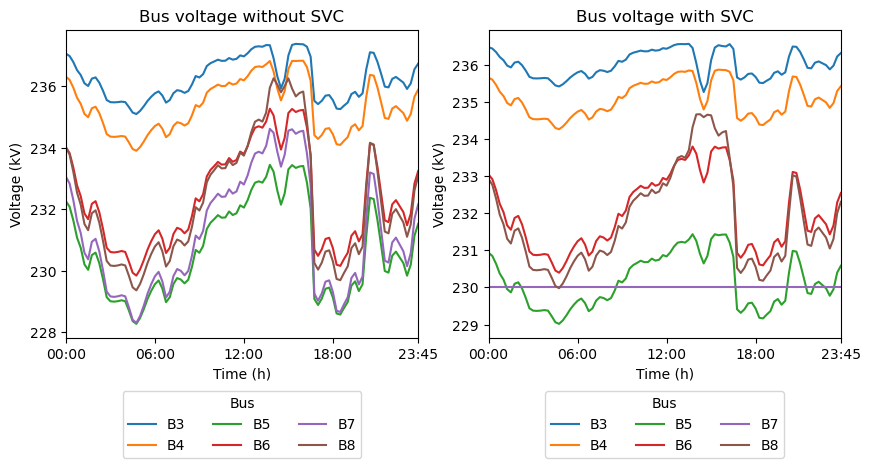

In [14]:
vm_pu_svc = ow.output["res_bus.vm_pu"].copy()
vm_pu_svc.columns = net.bus.name.values

_, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
legend_kwargs = {"loc": "upper center", "ncol": 3, "bbox_to_anchor": (0.5, -0.15), "title": "Bus"}
plot_result(ax1, 230 * vm_pu.iloc[:, 2:], "Bus voltage without SVC", "Voltage (kV)", 
            legend=True, legend_kwargs=legend_kwargs)
plot_result(ax2, 230 * vm_pu_svc.iloc[:, 2:], "Bus voltage with SVC", "Voltage (kV)", 
            legend=True, legend_kwargs=legend_kwargs)

The necessary thyristor firing angle to control the voltage is presented in the next plot.

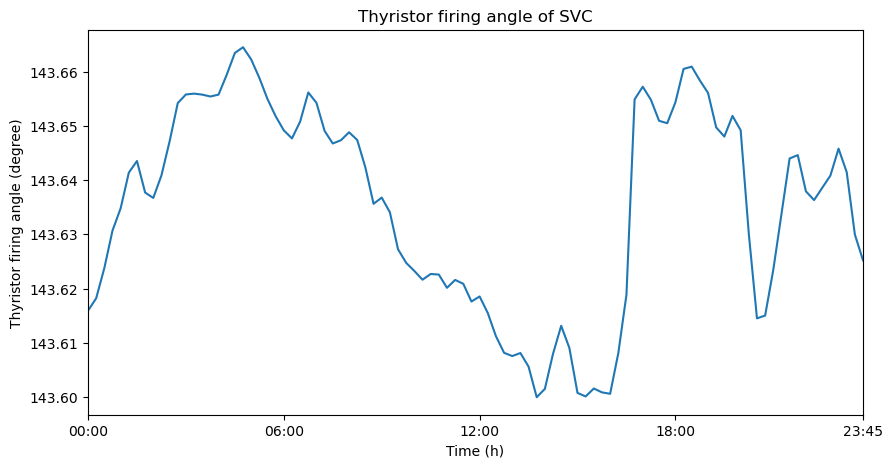

In [15]:
_, (ax) = plt.subplots(1, 1, figsize=(10, 5))
thyristor_firing_angle =  ow.output["res_svc.thyristor_firing_angle_degree"].copy() 

plot_result(ax, thyristor_firing_angle, 
            "Thyristor firing angle of SVC", "Thyristor firing angle (degree)")

# SSC use case (STATCOM)

The Static Synchronous Compensator (SSC), also known as STATCOM, is a shunt connected Flexible AC Transmission System
(FACTS) controller. It connects an AC system to a Voltage Source Converter (VSC) through a coupling transformer.
The SSC is used for reactive shunt compensation. Since the VSC is not connected to a power source, there is no active
power exchange between the SSC and the AC system. Consequently, the SSC can only control the voltage magnitude of
the AC system. At this use case, for the purpose of comparison, the SVC at bus B7 is replaced by a STATCOM to control the voltage amplitude to 230 kV.


In [16]:
# net = facts_case_study_grid()
# putting svc out of serivce and replace it with ssc
net.svc.in_service = False

pp.create_ssc(net, bus=6, r_ohm=0, x_ohm=5, set_vm_pu=1, controllable=True, in_service=True, vm_internal_pu=1.02, va_internal_degree=0)
# r_ohm, x_ohm are the parameters for the coupling transformer

pp.runpp(net, init='flat')

In [17]:
net.ssc

,name,bus,r_ohm,x_ohm,vm_internal_pu,va_internal_degree,set_vm_pu,controllable,in_service
0,None,6,0.0,5.0,1.02,0.0,1.0,True,True


The results of the power flow calculation for the SSC element are shown below: 

In [18]:
net.res_ssc

,q_mvar,vm_internal_pu,va_internal_degree,vm_pu,va_degree
0,9.140961,0.999136,-0.476388,1.0,-0.476388


we can confirm that the voltage magnitude at the bus 'B7' which has the index 6,is maintained at 1 vm_pu buy checking bus voltages

In [19]:
net.res_bus

,vm_pu,va_degree,p_mw,q_mvar
0,1.000000,0.000000,17.258065,15.967742
1,1.000000,14.814746,-405.712263,60.160494
2,1.027487,7.555741,0.000000,0.000000
3,1.023595,6.673662,130.000000,50.000000
4,1.002547,1.938715,120.000000,50.000000
5,1.011088,2.411446,80.000000,25.000000
6,1.000000,-0.476388,50.000000,34.140961
7,1.010037,0.611879,0.000000,0.000000


Next, we execute the timeseries simulation and plot the results, in comparison to svc.

In [20]:
ow.log_variable("res_ssc", "vm_internal_pu")

run_timeseries(net, time_steps=time_steps, continue_on_divergence=False, recycle=False,init='flat')

100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:01<00:00, 48.30it/s]


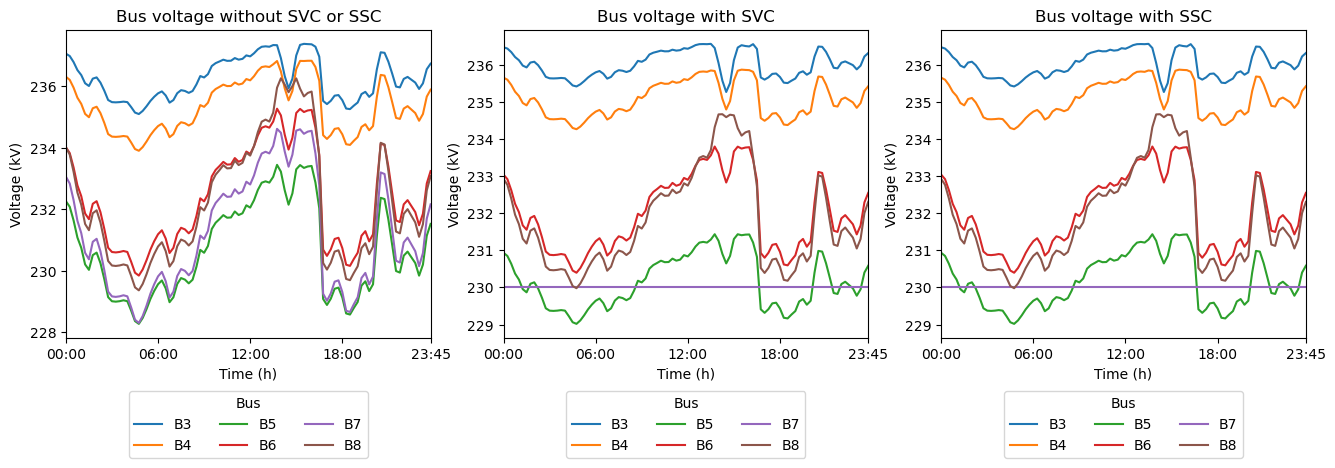

In [21]:
vm_pu_ssc = ow.output["res_bus.vm_pu"].copy()
vm_pu_ssc.columns = net.bus.name.values

_, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
legend_kwargs = {"loc": "upper center", "ncol": 3, "bbox_to_anchor": (0.5, -0.15), "title": "Bus"}
plot_result(ax1, 230 * vm_pu.iloc[:, 2:], "Bus voltage without SVC or SSC", "Voltage (kV)", 
            legend=True, legend_kwargs=legend_kwargs)
plot_result(ax2, 230 * vm_pu_svc.iloc[:, 2:], "Bus voltage with SVC", "Voltage (kV)", 
            legend=True, legend_kwargs=legend_kwargs)
plot_result(ax3, 230 * vm_pu_ssc.iloc[:, 2:], "Bus voltage with SSC", "Voltage (kV)", 
            legend=True, legend_kwargs=legend_kwargs)

Next, we compare the converter output voltage of the ssc device to the svc thyristor firing angle:

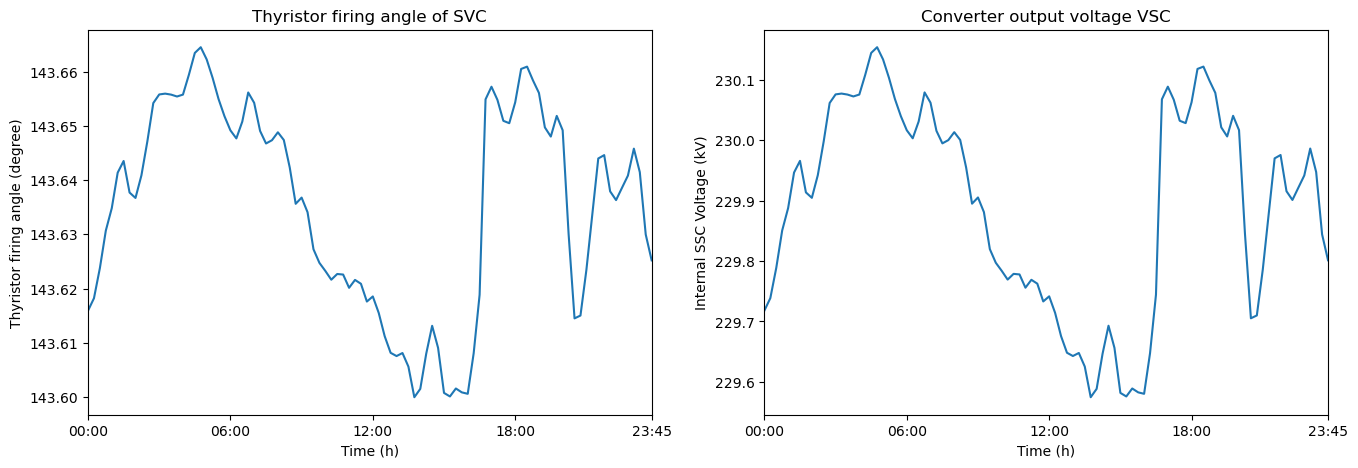

In [22]:
vm_pu_ssc = ow.output["res_ssc.vm_internal_pu"].copy()
vm_pu_ssc
_, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

plot_result(ax1, thyristor_firing_angle, 
            "Thyristor firing angle of SVC", "Thyristor firing angle (degree)")

plot_result(ax2, vm_pu_ssc*230, 
            "Converter output voltage VSC", "Internal SSC Voltage (kV)")

## TCSC use case

In this use case, we connect a TCSC controllable element in series at the start of line "L4", then we execute a time series simulation when the TCSC element is active and when it is not active. To this end, we create an auxiliary bus and connect the TCSC element to it and reconnect the line "L4".

The approach is to adjust the structure of the grid before running the simulation.

Initial set-up:

    B4--------(Line 4)-------B6 

New set-up:

    B4--(TCSC)----aux------(Line 4)-------B6

We need to apply the following steps:

- Step 1: define the necessary parameters: $X_L$, $X_{C_{var}}$, thyristor firing angle and the active power set point.
- Step 2: add an auxiliary bus to connect the TCSC and reconnect the line.
- Step 3: identify the line 4 and reconnect it - adjust the data so that the line 4 is connected to the bus B4 as from_bus and aux as to_bus.
- Step 4: create the TCSC betwen B4 and the auxiliary bus, provide the required parameters and set controllable to True. This will activate the TCSC element.

Note: if controllable is set to False, TCSC will act as a fixed impedance corresponding to the parameters $X_L$ and  $X_{C_{var}}$.

In [23]:
xl = 7.6
xc = -47

f = net.bus.loc[net.bus.name == "B4"].index.values[0]
t = net.bus.loc[net.bus.name == "B6"].index.values[0]
aux = pp.create_bus(net, 230, "aux")
l = net.line.loc[(net.line.from_bus == f) & (net.line.to_bus == t)].index.values[0]
net.line.loc[l, "from_bus"] = aux

pp.create_tcsc(net, from_bus=f, to_bus=aux, x_l_ohm=xl, x_cvar_ohm=xc, set_p_to_mw=-100, 
               thyristor_firing_angle_degree=140, controllable=True)
net.svc.in_service = False
net.ssc.in_service = False

net.tcsc

,name,from_bus,to_bus,x_l_ohm,x_cvar_ohm,set_p_to_mw,thyristor_firing_angle_degree,controllable,in_service,min_angle_degree,max_angle_degree
0,None,3,8,7.6,-47.0,-100.0,140.0,True,True,90.0,180.0


In [24]:
pp.runpp(net, init="dc")
net.res_tcsc

,thyristor_firing_angle_degree,x_ohm,p_from_mw,q_from_mvar,p_to_mw,q_to_mvar,pl_mw,ql_mvar,i_ka,vm_from_pu,va_from_degree,vm_to_pu,va_to_degree
0,119.797017,32.661474,100.0,-4.939336,-100.0,10.85824,0.0,5.918904,0.245778,1.022583,8.646513,1.027341,5.277211


Now, after loading the grid and creating TCSC element, we again set up the timeseries simulation. In the fololowing, we execute the first part of the calculation with the TCSC element with controllable set to True:

In [25]:
ow.log_variable("res_tcsc", "thyristor_firing_angle_degree")
ow.log_variable("res_tcsc", "p_from_mw")
ow.log_variable("res_tcsc", "q_from_mvar")
ow.log_variable("res_tcsc", "ql_mvar")

run_timeseries(net, time_steps[:48], continue_on_divergence=True, recycle=False, max_iteration=100, init="results")
p_controllable = ow.output["res_tcsc.p_from_mw"].copy()
angle_controllable = ow.output["res_tcsc.thyristor_firing_angle_degree"].copy()

100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 30.45it/s]


Now we set the TCSC parameter controllable to False and configure the thyristor firing angle to a fixed value of 90 degrees, then again execute the simulation. In the fololowing, we execute the second part of the calculation with the TCSC element acting as a fixed impedance:

In [26]:
net.tcsc.controllable = False
net.tcsc.thyristor_firing_angle_degree = 90
run_timeseries(net, time_steps[48:], continue_on_divergence=True, recycle=False, max_iteration=100, init="results")
p_not_controllable = ow.output["res_tcsc.p_from_mw"].copy()
angle_not_controllable = ow.output["res_tcsc.thyristor_firing_angle_degree"].copy()
p_total = pd.concat([p_controllable, p_not_controllable])
angle_total = pd.concat([angle_controllable, angle_not_controllable])

100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 54.04it/s]


Now we plot the active power transfer from buses 4 to 6 through the TCSC element and the line "L4" when TCSC is controllable (first half) and not controllable (second half):

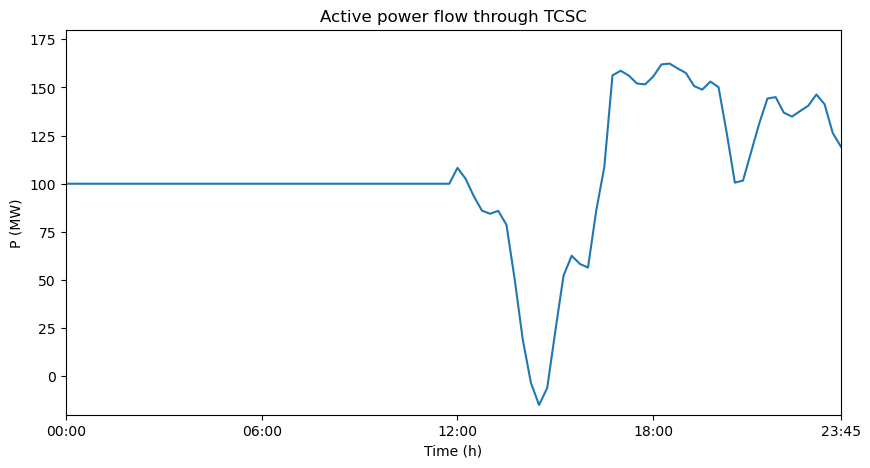

In [27]:
_, (ax) = plt.subplots(1, 1, figsize=(10, 5))
plot_result(ax, p_total, "Active power flow through TCSC", "P (MW)", [-20, 180])

The corresponding thyristor firing angle is shown in the plot below:

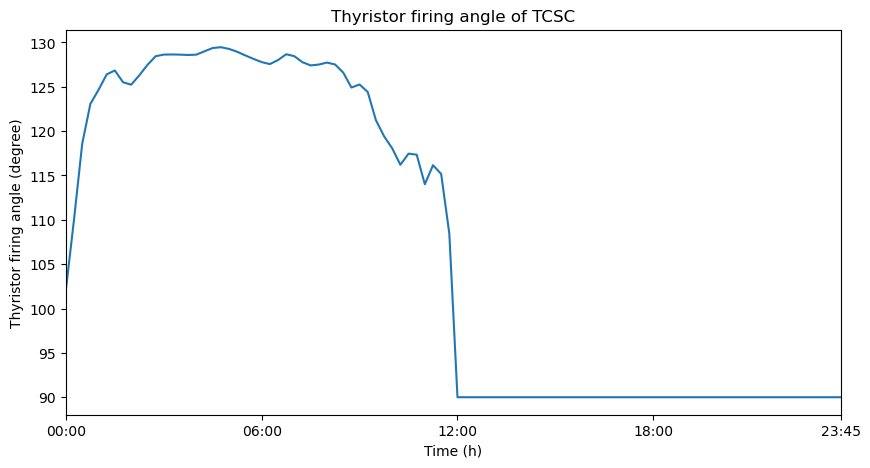

In [28]:
_, (ax) = plt.subplots(1, 1, figsize=(10, 5))
plot_result(ax, angle_total, "Thyristor firing angle of TCSC", "Thyristor firing angle (degree)")